# Comprehensive Wait Time Prediction Evaluation

## Analysis Overview:
 - **Validation Set**: 2023 data analysis
 - **Test Set**: 2024 data analysis  
 - **Prediction Modes**: Teacher Forcing vs Autoregressive (real conditions)
 - **Time Granularities**: Year, Month, Week, Day of Week, Hour
 - **Performance Metrics**: MAE, RMSE, R², sMAPE


In [1]:
!pip install --upgrade nbformat


In [2]:
import warnings
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from pathlib import Path
import sys
import os
from datetime import datetime
from typing import Dict, List, Optional, Tuple

# Setup
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure matplotlib and plotly for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Configure plotly for notebook display
import plotly.io as pio
pio.renderers.default = "notebook"

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))

# Import TCN modules
from TCN.inference.predictor import WaitTimePredictor
from TCN.datasets.data_utils import preprocess_data, create_features

print("🚀 Starting Comprehensive Model Evaluation")
print(f"📁 Project root: {project_root}")

# %% [markdown]
# ## Configuration and Setup

# %%
# Configuration
CONFIG = {
    'ride_name': 'blue_fire_megacoaster',  # Change this to your target ride
    'model_dir': '../models/cached_scheduled_sampling',
    'data_path': '../data/processed/ep/rides_nonoperating_bucket',  # Directory containing ride parquet files
    'splits_dir': '../data/processed/bucket_splits',   # Directory containing split indices
    'output_dir': '../TCN/results/evaluation'
}

# Create output directories
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

print(f"🎢 Evaluating ride: {CONFIG['ride_name']}")
print(f"📊 Output directory: {CONFIG['output_dir']}")
print(f"📁 Data directory: {CONFIG['data_path']}")
print(f"📑 Splits directory: {CONFIG['splits_dir']}")

# Check available rides
if Path(CONFIG['data_path']).exists():
    available_rides = [f.stem for f in Path(CONFIG['data_path']).glob('*.parquet')]
    print(f"📋 Available rides: {available_rides}")
else:
    print(f"⚠️  Data directory {CONFIG['data_path']} does not exist")

# %% [markdown]
# ## Fixed Data Loading and Preparation


🚀 Starting Comprehensive Model Evaluation
📁 Project root: /home/maiko/Documents/HSLU/DSPRO2/HSLU.DSPRO2.Waitless
🎢 Evaluating ride: blue_fire_megacoaster
📊 Output directory: ../TCN/results/evaluation
📁 Data directory: ../data/processed/ep/rides_nonoperating_bucket
📑 Splits directory: ../data/processed/bucket_splits
📋 Available rides: ['volo_da_vinci', 'josefinas_magical_imperial_journey', 'alpine_express_enzian', 'poppy_towers', 'kolumbusjolle', 'eurotower', 'atlantica_supersplash', 'vindjammer', 'whale_adventures__northern_lights', 'arena_of_football__be_part_of_it', 'fjordrafting', 'madame_freudenreich_curiosits', 'swiss_bob_run', 'eurosat__cancan_coaster', 'jim_button__journey_through_morrowland', 'euromir', 'blue_fire_megacoaster', 'voltron_nevera_powered_by_rimac', 'tirol_log_flume', 'pegasus', 'dancing_dingie', 'poseidon', 'old_mac_donalds_tractor_fun', 'arthur', 'matterhornblitz', 'castello_dei_medici', 'voletarium', 'baaa_express', 'atlantis_adventure', 'vienna_wave_swing__glck

DATA LOADING
📥 Loading data following training pattern
   📂 Loading ride data from: ../data/processed/ep/rides_nonoperating_bucket/blue_fire_megacoaster.parquet
   📊 Raw data shape: (30036, 69)
🔧 Preprocessing data for ride: blue_fire_megacoaster
📑 Loading split indices from ../data/processed/bucket_splits
   📊 Data splits - Train: 22061, Validation: 4246, Test: 3729
   📋 Static features: 66 columns
   📋 First 10 feature columns: ['closed', 'is_german_holiday', 'is_swiss_holiday', 'is_french_holiday', 'day_of_week', 'temperature', 'rain', 'weekday', 'is_weekend', 'month_sin']
   📋 Last 10 feature columns: ['season_summer', 'season_winter', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023', 'year_2024']
   🔍 Checking for training features...
   ⚠️  Extra features not in training: ['ride_name_alpine express enzian', 'ride_name_arena of football  be part of it', 'ride_name_arthur', 'ride_name_atlantica supersplash', 'ride_name_atlantis adventure', '

INFO:TCN.inference.predictor:Loading model configuration:
INFO:TCN.inference.predictor:  Config keys: ['epochs', 'patience', 'seed', 'use_wandb', 'base_data_dir', 'model_output_dir', 'splits_output_dir', 'data_path', 'target_ride', 'seq_length', 'batch_size', 'num_channels', 'kernel_size', 'num_layers', 'dropout', 'learning_rate', 'weight_decay', 'opening_hour', 'closing_hour', 'gb_n_estimators', 'gb_learning_rate', 'gb_max_depth', 'gb_min_samples_split', 'gb_min_samples_leaf', 'sampling_strategy', 'noise_factor', 'cache_update_frequency', 'max_cache_size', 'use_torch_compile', 'use_mixed_precision', 'run_name', 'static_features_size']
INFO:TCN.inference.predictor:  Original config: {'epochs': 100, 'patience': 25, 'seed': 42, 'use_wandb': True, 'base_data_dir': 'data/processed/ep/rides_nonoperating_bucket', 'model_output_dir': 'models', 'splits_output_dir': 'data/processed/bucket_splits', 'data_path': 'data/processed/ep/rides_nonoperating_bucket/blue_fire_megacoaster.parquet', 'target_

✅ Model loaded successfully
   🧠 TCN sequence length: 48
   📊 Static features: 35
   💻 Device: cuda

PREDICTION GENERATION
🔮 Making teacher forcing predictions for Validation (Teacher Forcing)


INFO:TCN.inference.predictor:🔧 Starting FIXED autoregressive prediction (same-day logic)
INFO:TCN.inference.predictor:   Sequence length: 48 timesteps
INFO:TCN.inference.predictor:   Opening hour: 11
INFO:TCN.inference.predictor:   📅 Starting predictions for 2023-04-04 at index 52
INFO:TCN.inference.predictor:   📅 Starting predictions for 2023-04-05 at index 68


   ⏱️  Prediction time: 35.71 seconds
   📊 Predictions shape: (4246, 46)
🔮 Making autoregressive predictions for Validation (Autoregressive)


INFO:TCN.inference.predictor:   📅 Starting predictions for 2023-04-06 at index 84
INFO:TCN.inference.predictor:   📅 Starting predictions for 2023-04-07 at index 100
INFO:TCN.inference.predictor:   📅 Starting predictions for 2023-04-08 at index 116
INFO:TCN.inference.predictor:   📊 Index 2000 (2023-08-04 09:00): Same-day predictions: 0.0%, Ground truth: 175.0%
INFO:TCN.inference.predictor:   📊 Index 4000 (2023-12-11 14:00): Same-day predictions: 12.5%, Ground truth: 175.0%
INFO:TCN.inference.predictor:✅ Completed FIXED autoregressive prediction:
INFO:TCN.inference.predictor:   📈 Total predictions: 4246
INFO:TCN.inference.predictor:   📅 Days with predictions: 269
INFO:TCN.inference.predictor:   🎯 Should see MUCH better performance due to same-day logic!


   ⏱️  Prediction time: 37.26 seconds
   📊 Predictions shape: (4246, 77)
🔮 Making teacher forcing predictions for Test (Teacher Forcing)


INFO:TCN.inference.predictor:🔧 Starting FIXED autoregressive prediction (same-day logic)
INFO:TCN.inference.predictor:   Sequence length: 48 timesteps
INFO:TCN.inference.predictor:   Opening hour: 11
INFO:TCN.inference.predictor:   📅 Starting predictions for 2024-05-06 at index 48
INFO:TCN.inference.predictor:   📅 Starting predictions for 2024-05-08 at index 60


   ⏱️  Prediction time: 32.99 seconds
   📊 Predictions shape: (3729, 77)
🔮 Making autoregressive predictions for Test (Autoregressive)


INFO:TCN.inference.predictor:   📅 Starting predictions for 2024-05-09 at index 76
INFO:TCN.inference.predictor:   📅 Starting predictions for 2024-05-10 at index 92
INFO:TCN.inference.predictor:   📅 Starting predictions for 2024-05-11 at index 108
INFO:TCN.inference.predictor:   📊 Index 2000 (2024-09-06 11:00): Same-day predictions: 0.0%, Ground truth: 175.0%
INFO:TCN.inference.predictor:✅ Completed FIXED autoregressive prediction:
INFO:TCN.inference.predictor:   📈 Total predictions: 3729
INFO:TCN.inference.predictor:   📅 Days with predictions: 237
INFO:TCN.inference.predictor:   🎯 Should see MUCH better performance due to same-day logic!


   ⏱️  Prediction time: 32.45 seconds
   📊 Predictions shape: (3729, 77)
✅ Generated predictions for 4 configurations

📊 DATA OVERVIEW:
   Validation (2023) (Teacher Forcing): 4,246 samples
      Date range: 2023-04-01 to 2023-12-30
      Years: [np.int32(2023)]

   Validation (2023) (Autoregressive): 4,246 samples
      Date range: 2023-04-01 to 2023-12-30
      Years: [np.int32(2023)]

   Test (2024) (Teacher Forcing): 3,729 samples
      Date range: 2024-04-26 to 2024-12-31
      Years: [np.int32(2024)]

   Test (2024) (Autoregressive): 3,729 samples
      Date range: 2024-04-26 to 2024-12-31
      Years: [np.int32(2024)]

OVERALL PERFORMANCE ANALYSIS

📊 OVERALL PERFORMANCE SUMMARY
📈 Validation (2023) - Teacher Forcing:
   MAE: 6.021 min
   RMSE: 8.420 min
   R²: 0.769
   sMAPE: 13.1%
   Samples: 4,186

📈 Validation (2023) - Autoregressive:
   MAE: 7.717 min
   RMSE: 10.885 min
   R²: 0.613
   sMAPE: 16.0%
   Samples: 4,186

📈 Test (2024) - Teacher Forcing:
   MAE: 5.989 min
   RMSE

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

✅ Completed temporal analysis: 1256 metric groups
📊 Creating matplotlib summary visualizations...


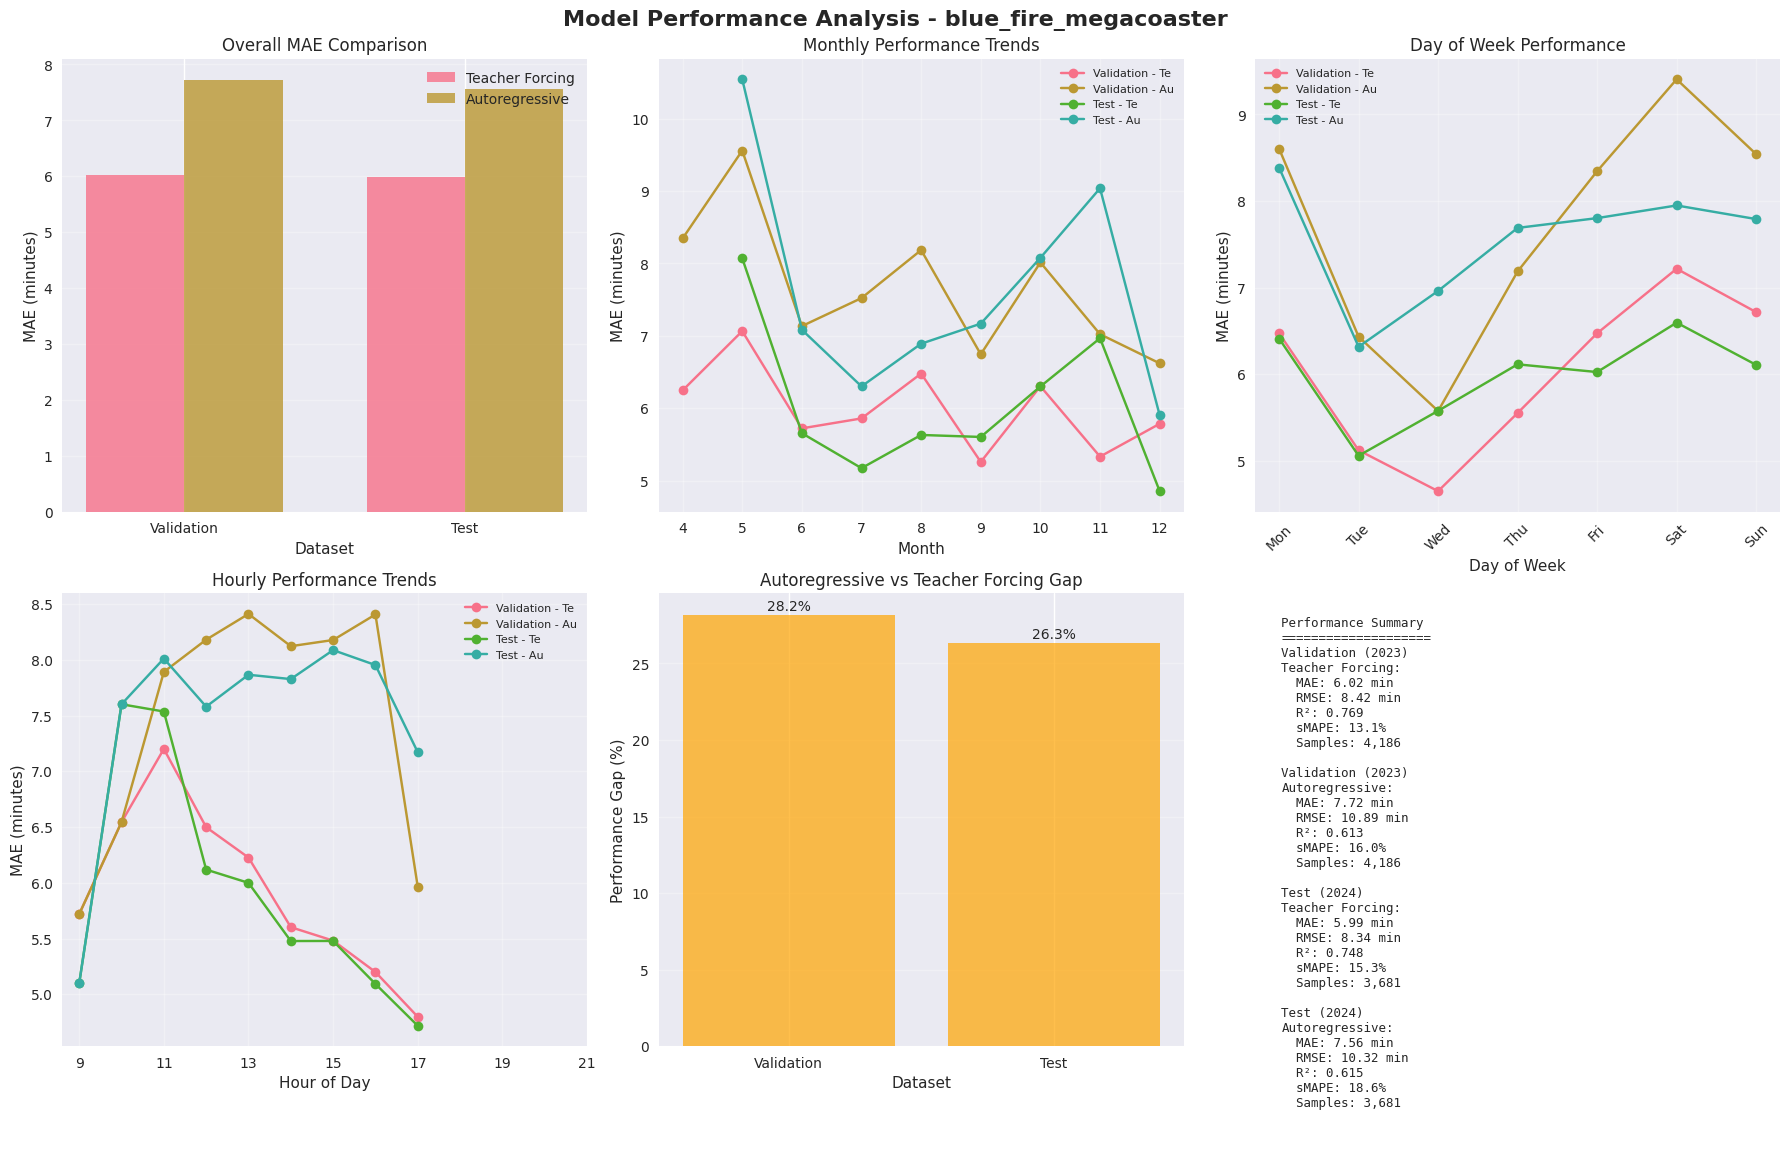

✅ Matplotlib summary plots displayed
📊 Creating Monthly performance plots...


📊 Creating Day of Week performance plots...


📊 Creating Hourly performance plots...


📊 Creating detailed performance analysis plots...


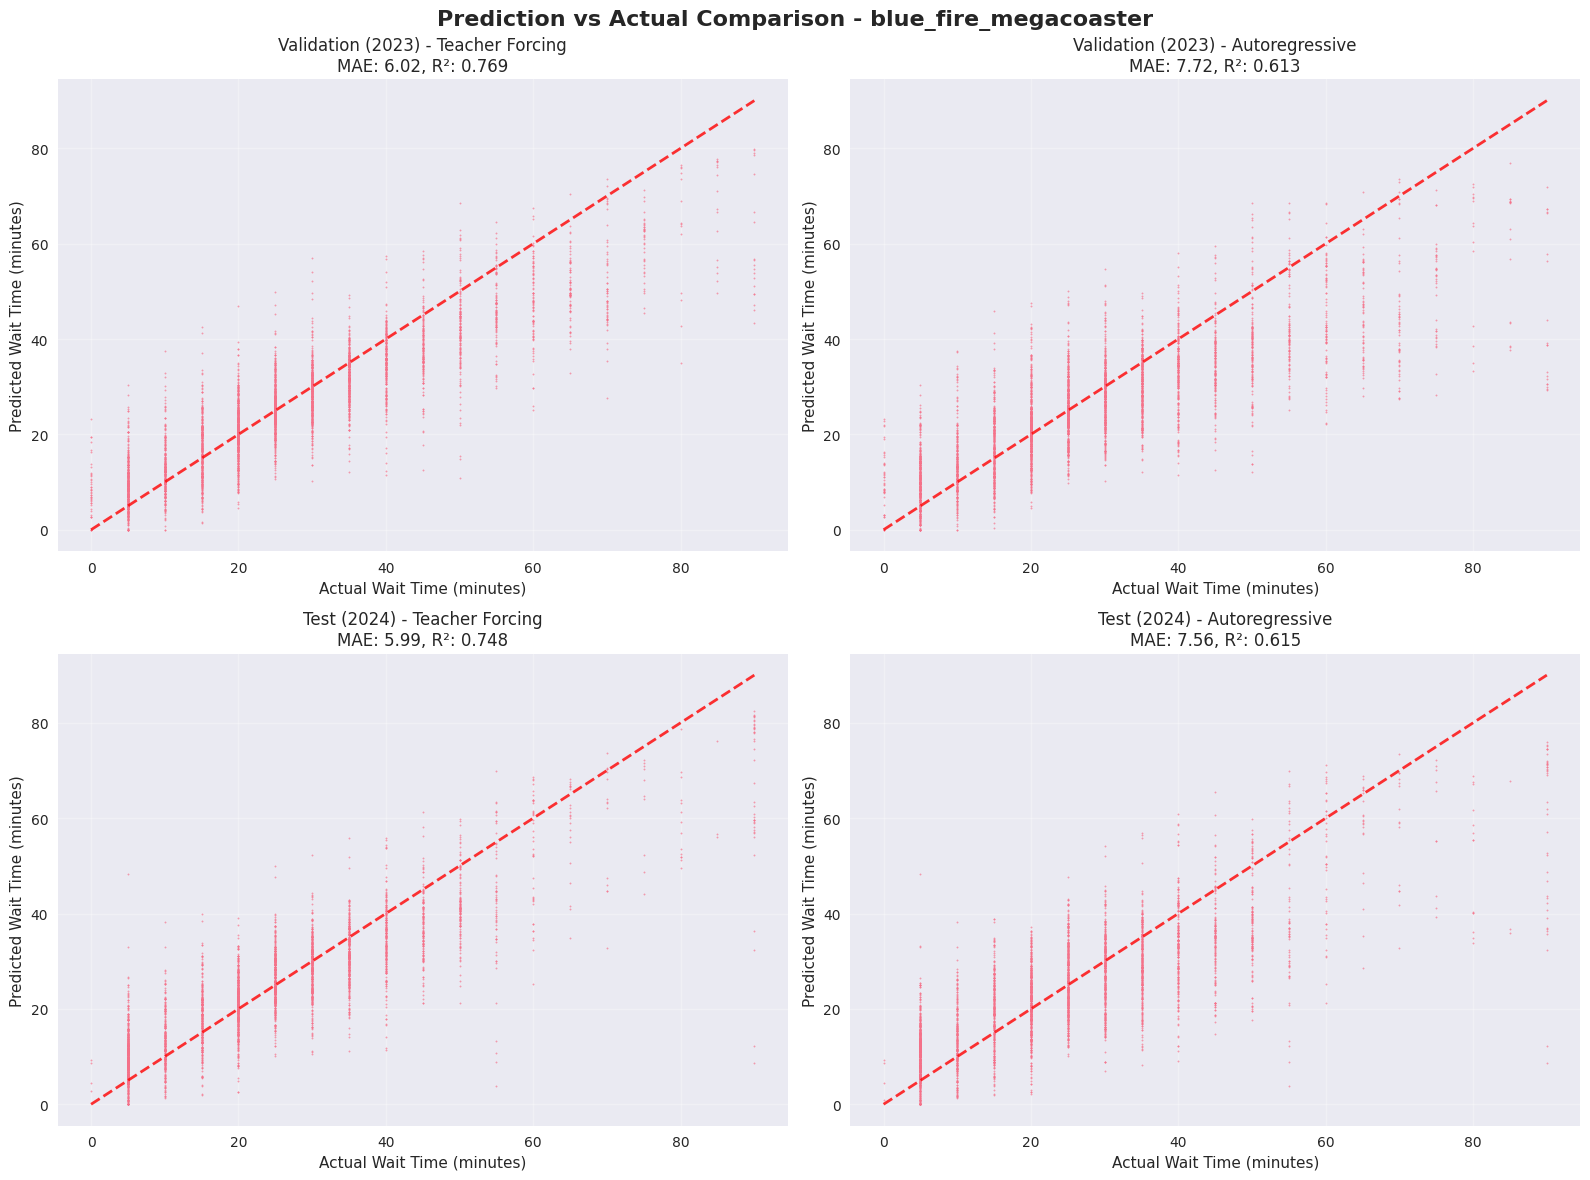

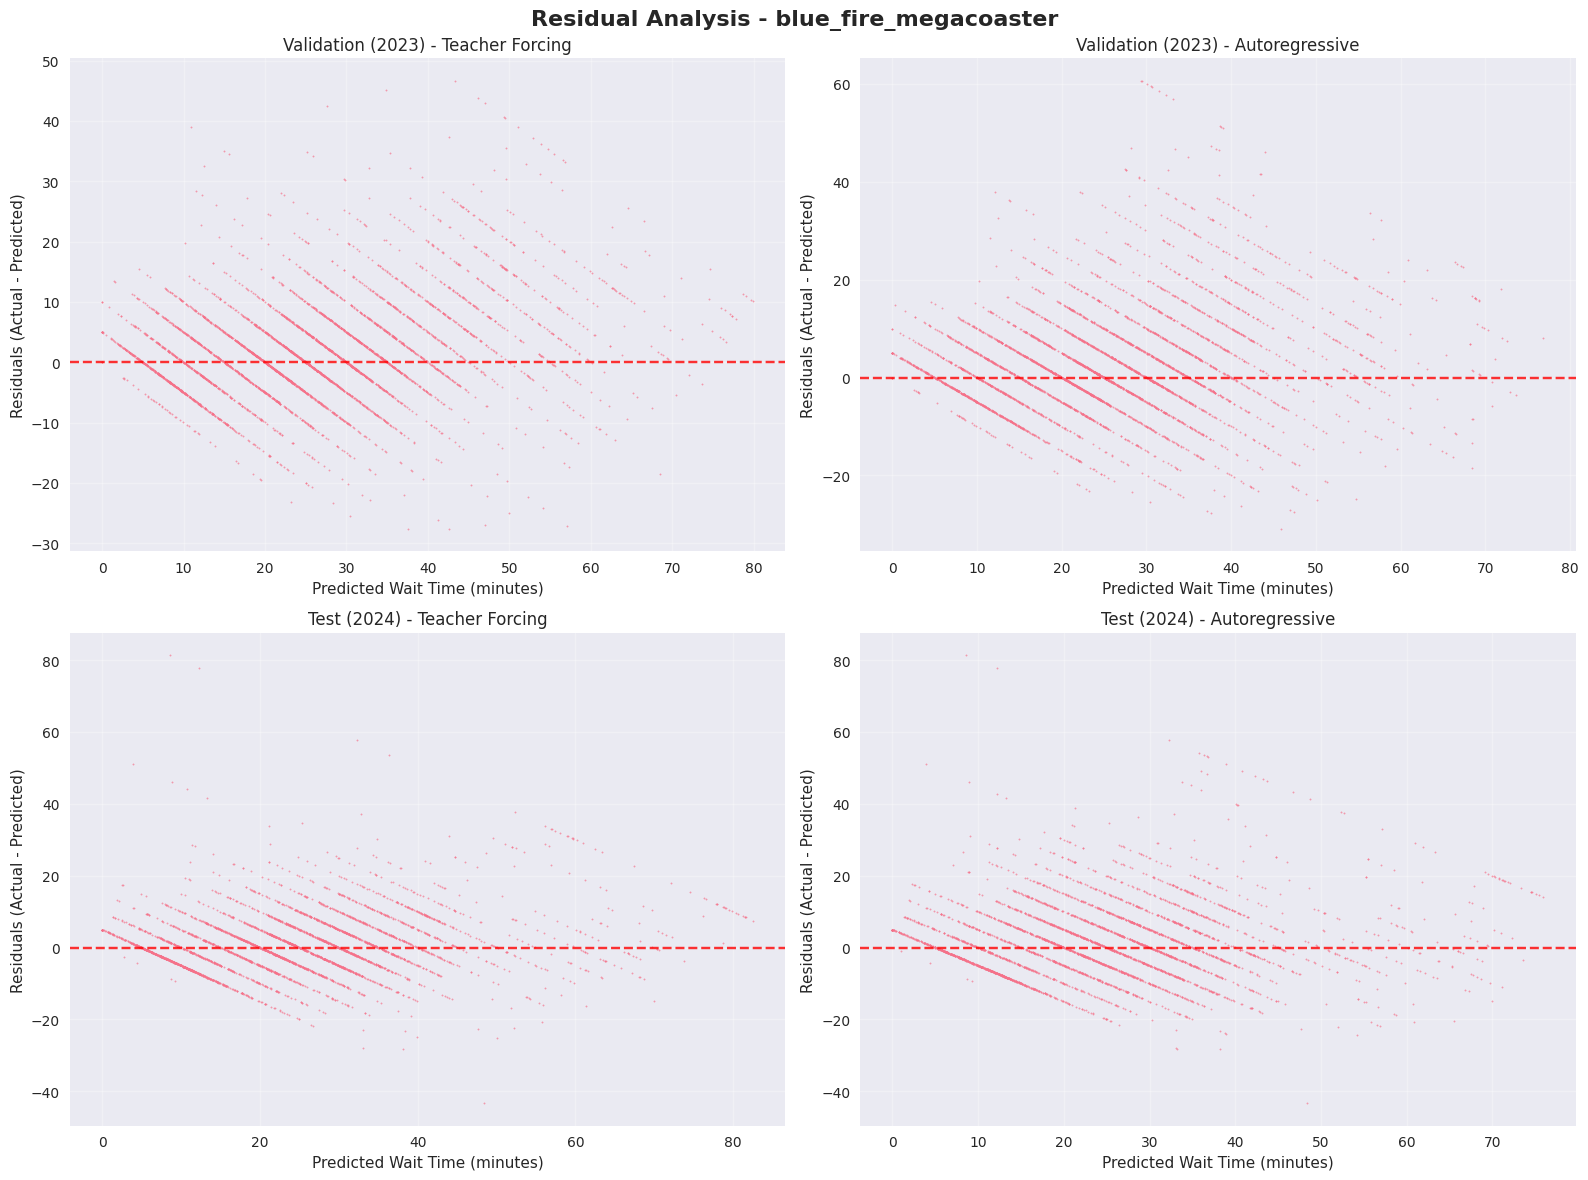

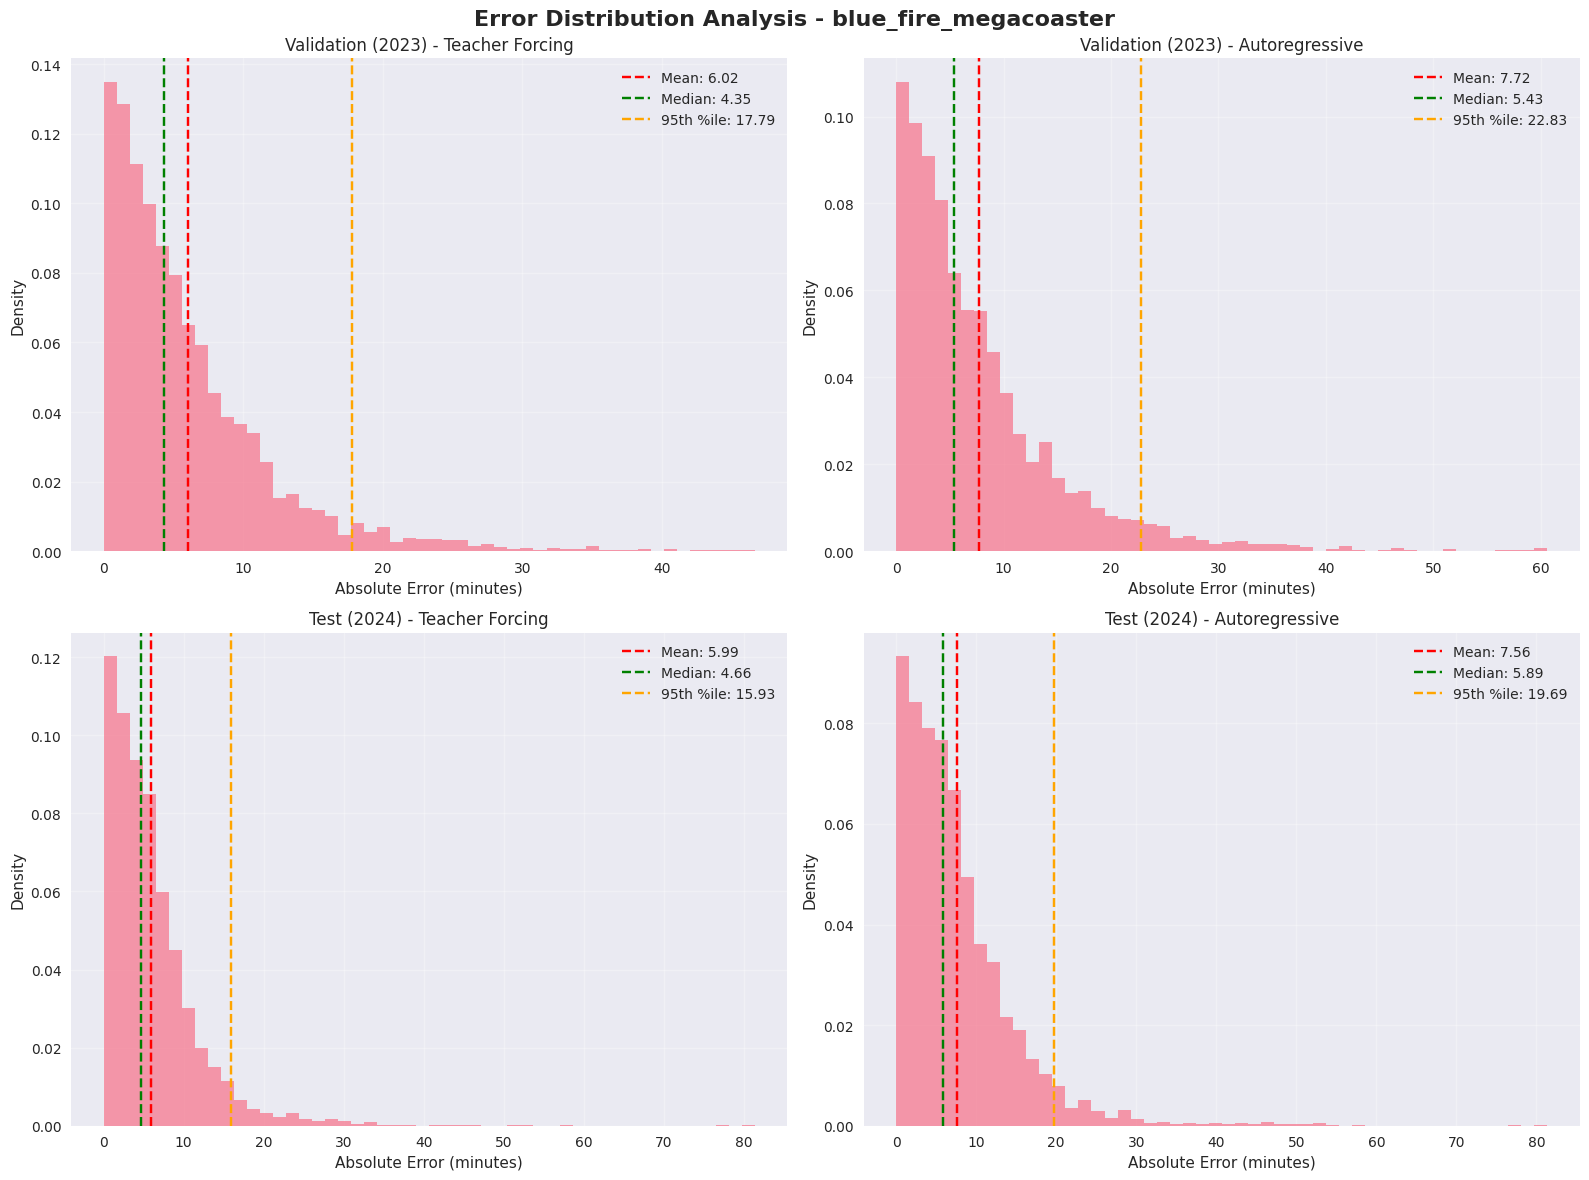


SAVING RESULTS
💾 Saved overall metrics to ../TCN/results/evaluation/overall_performance_metrics.csv
💾 Saved temporal metrics to ../TCN/results/evaluation/temporal_performance_metrics.csv
💾 Saved predictions to ../TCN/results/evaluation/predictions_val_tf.csv
💾 Saved predictions to ../TCN/results/evaluation/predictions_val_ar.csv
💾 Saved predictions to ../TCN/results/evaluation/predictions_test_tf.csv
💾 Saved predictions to ../TCN/results/evaluation/predictions_test_ar.csv
📄 Saved evaluation summary to ../TCN/results/evaluation/evaluation_summary.txt

🎉 EVALUATION COMPLETE!
✅ Evaluated 4 prediction configurations
✅ Generated 1256 temporal performance metrics
✅ Created comprehensive visualizations
✅ Saved results to ../TCN/results/evaluation

📊 Key Findings:
🏆 Best Performance: Test (2024) - Teacher Forcing
   MAE: 5.989 min, R²: 0.748
🔻 Worst Performance: Validation (2023) - Autoregressive
   MAE: 7.717 min, R²: 0.613

📁 All results saved to: /home/maiko/Documents/HSLU/DSPRO2/HSLU.DSPR

In [3]:

# Define expected training features once at the top
EXPECTED_TRAINING_FEATURES = [
    'closed', 'is_german_holiday', 'is_swiss_holiday', 'is_french_holiday', 
    'day_of_week', 'temperature', 'rain', 'weekday', 'is_weekend', 
    'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'weekday_sin', 
    'weekday_cos', 'minute_sin', 'minute_cos', 'temperature_unscaled', 'rain_unscaled',
    'part_of_day_afternoon', 'part_of_day_evening', 'part_of_day_morning', 'part_of_day_night', 
    'season_fall', 'season_spring', 'season_summer', 'season_winter', 
    'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021', 
    'year_2022', 'year_2023', 'year_2024'
]

# %%
# Data Loading and Preprocessing Functions

def load_data_splits(splits_dir: str, ride_name: str):
    """Load train/val/test split indices - same as training code"""
    print(f"📑 Loading split indices from {splits_dir}")
    
    train_indices = pd.read_parquet(f"{splits_dir}/train_indices.parquet")
    val_indices = pd.read_parquet(f"{splits_dir}/validation_indices.parquet")
    test_indices = pd.read_parquet(f"{splits_dir}/test_indices.parquet")
    
    ride_name_normalized = ride_name.replace(' ', '_')
    train_idx = train_indices[train_indices['ride_name'] == ride_name_normalized]['original_index'].values
    val_idx = val_indices[val_indices['ride_name'] == ride_name_normalized]['original_index'].values
    test_idx = test_indices[test_indices['ride_name'] == ride_name_normalized]['original_index'].values
    
    if len(train_idx) == 0 or len(val_idx) == 0 or len(test_idx) == 0:
        raise ValueError(f"No indices found for ride {ride_name}")
    
    print(f"   📊 Data splits - Train: {len(train_idx)}, Validation: {len(val_idx)}, Test: {len(test_idx)}")
    return train_idx, val_idx, test_idx

def preprocess_data_for_evaluation(df: pd.DataFrame, ride_name: str) -> pd.DataFrame:
    """Preprocess data for evaluation - same as training preprocessing"""
    print(f"🔧 Preprocessing data for ride: {ride_name}")
    
    # Remove time_bucket if present
    if 'time_bucket' in df.columns:
        df = df.drop(columns=['time_bucket'])
    
    # Filter for target ride (if ride columns exist)
    ride_col = f'ride_name_{ride_name}'
    if ride_col in df.columns:
        df = df[df[ride_col] == 1].copy()
        print(f"   Filtered data for ride {ride_name}: {len(df)} samples")
        
        # Remove all ride_name columns
        ride_cols = [col for col in df.columns if col.startswith('ride_name_')]
        df = df.drop(columns=ride_cols)
    
    # Handle missing values
    df = df.fillna(0)
    
    return df

def create_features_for_evaluation(df: pd.DataFrame):
    """Create static feature columns - EXACTLY like training (data_utils.py)"""
    # Static features are everything except wait_time and timestamp
    static_feature_cols = [col for col in df.columns 
                          if col not in ['wait_time', 'timestamp']]
    
    print(f"   📋 Static features: {len(static_feature_cols)} columns")
    print(f"   📋 First 10 feature columns: {static_feature_cols[:10]}")
    print(f"   📋 Last 10 feature columns: {static_feature_cols[-10:]}")
    
    # Verify we have the expected features
    print(f"   🔍 Checking for training features...")
    missing_features = [f for f in EXPECTED_TRAINING_FEATURES if f not in static_feature_cols]
    extra_features = [f for f in static_feature_cols if f not in EXPECTED_TRAINING_FEATURES]
    
    if missing_features:
        print(f"   ⚠️  Missing training features: {missing_features}")
    if extra_features:
        print(f"   ⚠️  Extra features not in training: {extra_features}")
    
    # Verify day_of_week is numeric
    if 'day_of_week' in df.columns:
        print(f"   📊 day_of_week dtype: {df['day_of_week'].dtype}")
        print(f"   📊 day_of_week sample values: {df['day_of_week'].head(3).tolist()}")
        
        if df['day_of_week'].dtype == 'object':
            print(f"   ⚠️  WARNING: day_of_week is object type, should be numeric!")
    
    return df, static_feature_cols

def load_and_prepare_data(data_path: str, splits_dir: str, ride_name: str):
    """Load and prepare data following the EXACT same pattern as training"""
    print(f"📥 Loading data following training pattern")
    
    # Determine ride file name
    ride_name_normalized = ride_name.replace(' ', '_').lower()
    ride_file = f"{ride_name_normalized}.parquet"
    full_data_path = Path(data_path) / ride_file
    
    if not full_data_path.exists():
        # Try without normalization
        ride_file = f"{ride_name}.parquet"
        full_data_path = Path(data_path) / ride_file
        
        if not full_data_path.exists():
            raise FileNotFoundError(f"Could not find ride data file. Tried: {ride_name_normalized}.parquet and {ride_name}.parquet in {data_path}")
    
    print(f"   📂 Loading ride data from: {full_data_path}")
    
    # Load main data file
    df = pd.read_parquet(full_data_path)
    print(f"   📊 Raw data shape: {df.shape}")
    
    # Apply preprocessing in EXACT same order as training
    # Step 1: Preprocess data (same as training)
    df = preprocess_data_for_evaluation(df, ride_name)
    
    # Step 2: Load split indices (same as training)
    train_indices, val_indices, test_indices = load_data_splits(splits_dir, ride_name)
    
    # Step 3: Create features EXACTLY like training (BEFORE splitting data)
    df, static_feature_cols = create_features_for_evaluation(df)
    
    # Step 4: Split data using indices (same as training)
    train_df = df.iloc[train_indices].copy()
    val_df = df.iloc[val_indices].copy()
    test_df = df.iloc[test_indices].copy()
    
    print(f"   ✅ Train data: {train_df.shape}")
    print(f"   ✅ Validation data: {val_df.shape}")
    print(f"   ✅ Test data: {test_df.shape}")
    
    # Add analysis features ONLY for visualization, NOT for model input
    for dataset_name, dataset in [('validation', val_df), ('test', test_df)]:
        dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
        
        # Add analysis features with different names to avoid conflicts
        dataset['analysis_year'] = dataset['timestamp'].dt.year
        dataset['analysis_month'] = dataset['timestamp'].dt.month
        dataset['analysis_week'] = dataset['timestamp'].dt.isocalendar().week
        dataset['analysis_day_name'] = dataset['timestamp'].dt.day_name()
        dataset['analysis_hour'] = dataset['timestamp'].dt.hour
        dataset['analysis_date'] = dataset['timestamp'].dt.date
        
        # Filter operational hours (9 AM to 9 PM)
        operational_mask = (dataset['analysis_hour'] >= 9) & (dataset['analysis_hour'] <= 21)
        print(f"   📊 {dataset_name.capitalize()} operational hours: {operational_mask.sum()} / {len(dataset)} samples")

    return val_df, test_df

# %%
# Data Loading
print("=" * 60)
print("DATA LOADING")
print("=" * 60)

try:
    val_data, test_data = load_and_prepare_data(
        CONFIG['data_path'], 
        CONFIG['splits_dir'], 
        CONFIG['ride_name']
    )
    print("✅ Data loaded successfully")
    print(f"   📊 Validation data (operational): {val_data.shape}")
    print(f"   📊 Test data (operational): {test_data.shape}")
    
    # Display basic data info
    print(f"\n📅 Data date ranges:")
    print(f"   Validation: {val_data['timestamp'].min()} to {val_data['timestamp'].max()}")
    print(f"   Test: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    val_data = None
    test_data = None

# %%
# Enhanced Model Class with Fixed Preprocessing

class FixedWaitTimePredictor(WaitTimePredictor):
    """Enhanced predictor with fixed feature preprocessing"""
    
    def preprocess_input(self, df: pd.DataFrame) -> pd.DataFrame:
        """Preprocess input data to match training data format exactly"""
        
        # Step 1: Apply same preprocessing as training (from data_utils.py)
        df = preprocess_data(df, self.ride_name)
        
        # Step 2: Create features exactly like training (from data_utils.py)
        static_feature_cols = [col for col in df.columns 
                              if col not in ['wait_time', 'timestamp']]
        
        logger.info(f"Initial features after preprocessing: {len(static_feature_cols)}")
        
        # Step 3: Get expected training features from config or use default
        expected_features = (self.config.get('static_feature_cols') or EXPECTED_TRAINING_FEATURES)
        
        if 'static_feature_cols' in self.config and self.config['static_feature_cols']:
            logger.info(f"Using saved feature columns from model config: {len(expected_features)} features")
        else:
            logger.info(f"Using default expected features: {len(expected_features)} features")
        
        # Step 4: Filter to only include expected training features in exact order
        final_feature_cols = []
        missing_features = []
        
        for feature in expected_features:
            if feature in static_feature_cols and feature in df.columns:
                if pd.api.types.is_numeric_dtype(df[feature]):
                    final_feature_cols.append(feature)
                else:
                    logger.error(f"Feature '{feature}' exists but is not numeric (dtype: {df[feature].dtype})")
                    # Try to fix day_of_week encoding
                    if feature == 'day_of_week' and df[feature].dtype == 'object':
                        logger.warning(f"Attempting to fix day_of_week encoding...")
                        day_mapping = {
                            'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
                            'Friday': 4, 'Saturday': 5, 'Sunday': 6
                        }
                        if all(val in day_mapping for val in df[feature].dropna().unique()):
                            df[feature] = df[feature].map(day_mapping)
                            final_feature_cols.append(feature)
                            logger.info(f"Successfully converted day_of_week to numeric")
                        else:
                            missing_features.append(feature)
                    else:
                        missing_features.append(feature)
            else:
                missing_features.append(feature)
        
        # Report findings
        extra_features = [f for f in static_feature_cols if f not in expected_features]
        
        logger.info(f"Feature matching results:")
        logger.info(f"  Expected features: {len(expected_features)}")
        logger.info(f"  Found and valid: {len(final_feature_cols)}")
        logger.info(f"  Missing features: {missing_features}")
        logger.info(f"  Extra features (ignored): {extra_features}")
        
        # Verify feature count matches model expectations
        expected_count = self.config['static_features_size']
        
        if len(final_feature_cols) == expected_count:
            logger.info(f"✅ Feature count matches exactly: {len(final_feature_cols)}")
            self.static_feature_cols = final_feature_cols
        elif len(final_feature_cols) < expected_count:
            logger.error(f"❌ Not enough features: {len(final_feature_cols)} < {expected_count}")
            logger.error(f"Missing features: {missing_features}")
            raise ValueError(f"Feature count mismatch: need {expected_count} features, got {len(final_feature_cols)}")
        else:
            logger.warning(f"⚠️ Too many features: {len(final_feature_cols)} > {expected_count}")
            # Take exactly the expected number in the correct order
            self.static_feature_cols = final_feature_cols[:expected_count]
        
        logger.info(f"Final selected features ({len(self.static_feature_cols)}):")
        for i, feature in enumerate(self.static_feature_cols):
            logger.info(f"  {i+1:2d}. {feature}")
        
        return df

def make_predictions(predictor, data, data_name, use_autoregressive=True):
    """Make predictions and return results with timing info"""
    mode_text = "autoregressive" if use_autoregressive else "teacher forcing"
    print(f"🔮 Making {mode_text} predictions for {data_name}")
    
    start_time = datetime.now()
    predictions_df = predictor.predict_batch(data.copy(), use_autoregressive=use_autoregressive)
    end_time = datetime.now()
    duration = end_time - start_time
    
    print(f"   ⏱️  Prediction time: {duration.total_seconds():.2f} seconds")
    print(f"   📊 Predictions shape: {predictions_df.shape}")
    
    return predictions_df

# %%
# Model Initialization
print("=" * 60)
print("MODEL INITIALIZATION")
print("=" * 60)

try:
    predictor = WaitTimePredictor(CONFIG['ride_name'], CONFIG['model_dir'])
    print("✅ Model loaded successfully")
    print(f"   🧠 TCN sequence length: {predictor.seq_length}")
    print(f"   📊 Static features: {predictor.static_features_size}")
    print(f"   💻 Device: {predictor.device}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# %%
# Prediction Generation
print("\n" + "=" * 60)
print("PREDICTION GENERATION")
print("=" * 60)

results = {}

# Validation predictions (using validation split indices)
if val_data is not None:
    # Teacher forcing (ideal conditions)
    val_tf = make_predictions(predictor, val_data, "Validation (Teacher Forcing)", use_autoregressive=False)
    val_tf['prediction_mode'] = 'Teacher Forcing'
    val_tf['dataset'] = 'Validation (2023)' if val_data['analysis_year'].iloc[0] <= 2023 else f'Validation ({val_data["analysis_year"].iloc[0]})'
    
    # Autoregressive (real conditions)
    val_ar = make_predictions(predictor, val_data, "Validation (Autoregressive)", use_autoregressive=True)
    val_ar['prediction_mode'] = 'Autoregressive'
    val_ar['dataset'] = 'Validation (2023)' if val_data['analysis_year'].iloc[0] <= 2023 else f'Validation ({val_data["analysis_year"].iloc[0]})'
    
    results['val_tf'] = val_tf
    results['val_ar'] = val_ar

# Test predictions (using test split indices)
if test_data is not None:
    # Teacher forcing (ideal conditions)
    test_tf = make_predictions(predictor, test_data, "Test (Teacher Forcing)", use_autoregressive=False)
    test_tf['prediction_mode'] = 'Teacher Forcing'
    test_tf['dataset'] = 'Test (2024)' if test_data['analysis_year'].iloc[0] >= 2024 else f'Test ({test_data["analysis_year"].iloc[0]})'
    
    # Autoregressive (real conditions)
    test_ar = make_predictions(predictor, test_data, "Test (Autoregressive)", use_autoregressive=True)
    test_ar['prediction_mode'] = 'Autoregressive'
    test_ar['dataset'] = 'Test (2024)' if test_data['analysis_year'].iloc[0] >= 2024 else f'Test ({test_data["analysis_year"].iloc[0]})'
    
    results['test_tf'] = test_tf
    results['test_ar'] = test_ar

print(f"✅ Generated predictions for {len(results)} configurations")

# Display data overview
if results:
    print("\n📊 DATA OVERVIEW:")
    print("=" * 40)
    for key, df in results.items():
        dataset_name = df['dataset'].iloc[0]
        mode = df['prediction_mode'].iloc[0]
        date_range = f"{df['timestamp'].min().strftime('%Y-%m-%d')} to {df['timestamp'].max().strftime('%Y-%m-%d')}"
        print(f"   {dataset_name} ({mode}): {len(df):,} samples")
        print(f"      Date range: {date_range}")
        print(f"      Years: {sorted(df['analysis_year'].unique())}")
        print()

# %%
# Evaluation Functions

def calculate_metrics(y_true, y_pred, name=""):
    """Calculate comprehensive evaluation metrics"""
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # Remove invalid predictions
    valid_mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[valid_mask]
    y_pred_clean = y_pred[valid_mask]
    
    if len(y_true_clean) == 0:
        return {
            'mae': np.nan, 'rmse': np.nan, 'r2': np.nan, 'smape': np.nan,
            'n_samples': 0, 'name': name
        }
    
    # Calculate metrics
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)
    
    # sMAPE calculation
    non_zero_mask = y_true_clean > 0.1
    if np.sum(non_zero_mask) > 0:
        y_true_nz = y_true_clean[non_zero_mask]
        y_pred_nz = y_pred_clean[non_zero_mask]
        smape = np.mean(np.abs(y_true_nz - y_pred_nz) / (np.abs(y_true_nz) + np.abs(y_pred_nz))) * 100
    else:
        smape = np.nan
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'smape': smape,
        'n_samples': len(y_true_clean),
        'name': name
    }

def evaluate_temporal_performance(df, predictor, group_by_cols, group_name):
    """Evaluate performance across different temporal groupings using analysis columns"""
    print(f"📈 Evaluating {group_name} performance")
    
    # Filter valid predictions (after sequence length)
    valid_df = df.iloc[predictor.seq_length:].copy()
    
    # Filter operational data only
    if 'closed' in valid_df.columns:
        valid_df = valid_df[valid_df['closed'] == 0]
    
    # Map group_by_cols to analysis columns
    analysis_group_cols = []
    for col in group_by_cols:
        if col == 'month':
            analysis_group_cols.append('analysis_month')
        elif col == 'week':
            analysis_group_cols.append('analysis_week')
        elif col == 'day_of_week':
            analysis_group_cols.append('analysis_day_name')
        elif col == 'hour':
            analysis_group_cols.append('analysis_hour')
        elif col == 'date':
            analysis_group_cols.append('analysis_date')
        else:
            analysis_group_cols.append(col)
    
    # Group by specified columns
    metrics_list = []
    
    for group_vals, group_df in valid_df.groupby(analysis_group_cols):
        if len(group_df) < 10:  # Skip groups with too few samples
            continue
            
        metrics = calculate_metrics(
            group_df['wait_time'].values,
            group_df['wait_time_prediction'].values,
            name=group_vals if isinstance(group_vals, str) else "_".join(map(str, group_vals))
        )
        
        # Add grouping information using original column names
        if isinstance(group_vals, tuple):
            for i, col in enumerate(group_by_cols):
                metrics[col] = group_vals[i]
        else:
            metrics[group_by_cols[0]] = group_vals
        
        metrics['group_type'] = group_name
        metrics['dataset'] = df['dataset'].iloc[0]
        metrics['prediction_mode'] = df['prediction_mode'].iloc[0]
        
        metrics_list.append(metrics)
    
    return pd.DataFrame(metrics_list)

# %%
# Overall Performance Analysis
print("=" * 60)
print("OVERALL PERFORMANCE ANALYSIS")
print("=" * 60)

# Calculate overall metrics for each configuration
overall_metrics = []

for key, df in results.items():
    # Filter valid predictions
    valid_df = df.iloc[predictor.seq_length:].copy()
    if 'closed' in valid_df.columns:
        valid_df = valid_df[valid_df['closed'] == 0]
    
    metrics = calculate_metrics(
        valid_df['wait_time'].values,
        valid_df['wait_time_prediction'].values,
        name=key
    )
    
    metrics['dataset'] = df['dataset'].iloc[0]
    metrics['prediction_mode'] = df['prediction_mode'].iloc[0]
    overall_metrics.append(metrics)

overall_df = pd.DataFrame(overall_metrics)
print("\n📊 OVERALL PERFORMANCE SUMMARY")
print("=" * 60)
for _, row in overall_df.iterrows():
    print(f"📈 {row['dataset']} - {row['prediction_mode']}:")
    print(f"   MAE: {row['mae']:.3f} min")
    print(f"   RMSE: {row['rmse']:.3f} min") 
    print(f"   R²: {row['r2']:.3f}")
    print(f"   sMAPE: {row['smape']:.1f}%")
    print(f"   Samples: {row['n_samples']:,}")
    print()

# Performance gap analysis
if len(overall_df) >= 2:
    print("🎭 PERFORMANCE GAP ANALYSIS")
    print("=" * 60)
    
    for dataset in overall_df['dataset'].unique():
        dataset_metrics = overall_df[overall_df['dataset'] == dataset]
        if len(dataset_metrics) == 2:
            tf_metrics = dataset_metrics[dataset_metrics['prediction_mode'] == 'Teacher Forcing'].iloc[0]
            ar_metrics = dataset_metrics[dataset_metrics['prediction_mode'] == 'Autoregressive'].iloc[0]
            
            mae_gap = ar_metrics['mae'] - tf_metrics['mae']
            rmse_gap = ar_metrics['rmse'] - tf_metrics['rmse']
            r2_gap = tf_metrics['r2'] - ar_metrics['r2']
            
            print(f"📊 {dataset}:")
            print(f"   MAE Gap: {mae_gap:.3f} min ({mae_gap/tf_metrics['mae']*100:.1f}%)")
            print(f"   RMSE Gap: {rmse_gap:.3f} min ({rmse_gap/tf_metrics['rmse']*100:.1f}%)")
            print(f"   R² Gap: {r2_gap:.3f} ({r2_gap/tf_metrics['r2']*100:.1f}%)")
            print()

# %%
# Temporal Performance Analysis
print("=" * 60)
print("TEMPORAL PERFORMANCE ANALYSIS")
print("=" * 60)

# Analyze performance across different time granularities
temporal_metrics = []

for key, df in results.items():
    print(f"\n🔍 Analyzing {key}")
    
    # Monthly performance
    monthly_metrics = evaluate_temporal_performance(df, predictor, ['month'], 'Monthly')
    temporal_metrics.append(monthly_metrics)
    
    # Weekly performance (by week number)
    weekly_metrics = evaluate_temporal_performance(df, predictor, ['week'], 'Weekly')
    temporal_metrics.append(weekly_metrics)
    
    # Day of week performance
    dow_metrics = evaluate_temporal_performance(df, predictor, ['day_of_week'], 'Day of Week')
    temporal_metrics.append(dow_metrics)
    
    # Hourly performance
    hourly_metrics = evaluate_temporal_performance(df, predictor, ['hour'], 'Hourly')
    temporal_metrics.append(hourly_metrics)
    
    # Daily performance (for trend analysis)
    daily_metrics = evaluate_temporal_performance(df, predictor, ['date'], 'Daily')
    temporal_metrics.append(daily_metrics)

# Combine all temporal metrics
all_temporal_metrics = pd.concat(temporal_metrics, ignore_index=True)

print(f"✅ Completed temporal analysis: {len(all_temporal_metrics)} metric groups")

# %%
# Visualization Functions

def create_performance_comparison_plot(metrics_df, group_type, metric='mae'):
    """Create comparison plots for different temporal groupings"""
    
    # Filter for specific group type
    group_metrics = metrics_df[metrics_df['group_type'] == group_type]
    
    if len(group_metrics) == 0:
        return None
    
    # Create subplot
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=['Teacher Forcing', 'Autoregressive', 
                       'Performance Gap', 'Sample Counts'],
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": True}]]
    )
    
    # Group by prediction mode and dataset
    for dataset in group_metrics['dataset'].unique():
        dataset_metrics = group_metrics[group_metrics['dataset'] == dataset]
        
        for mode in dataset_metrics['prediction_mode'].unique():
            mode_metrics = dataset_metrics[dataset_metrics['prediction_mode'] == mode]
            
            if len(mode_metrics) == 0:
                continue
            
            # Determine x-axis values based on group type
            if group_type == 'Monthly':
                x_vals = mode_metrics['month']
                x_title = 'Month'
            elif group_type == 'Day of Week':
                x_vals = mode_metrics['day_of_week']
                x_title = 'Day of Week'
            elif group_type == 'Hourly':
                x_vals = mode_metrics['hour']
                x_title = 'Hour'
            elif group_type == 'Weekly':
                x_vals = mode_metrics['week']
                x_title = 'Week'
            else:
                x_vals = range(len(mode_metrics))
                x_title = 'Group'
            
            # Plot on appropriate subplot
            row = 1 if mode == 'Teacher Forcing' else 1
            col = 1 if mode == 'Teacher Forcing' else 2
            
            fig.add_trace(
                go.Scatter(
                    x=x_vals,
                    y=mode_metrics[metric],
                    mode='lines+markers',
                    name=f"{dataset} - {mode}",
                    line=dict(width=2),
                    marker=dict(size=6)
                ),
                row=row, col=col
            )
    
    # Calculate and plot performance gaps
    for dataset in group_metrics['dataset'].unique():
        dataset_metrics = group_metrics[group_metrics['dataset'] == dataset]
        
        tf_metrics = dataset_metrics[dataset_metrics['prediction_mode'] == 'Teacher Forcing']
        ar_metrics = dataset_metrics[dataset_metrics['prediction_mode'] == 'Autoregressive']
        
        if len(tf_metrics) > 0 and len(ar_metrics) > 0:
            # Merge on group identifier
            group_col = group_type.lower().replace(' ', '_')
            if group_type == 'Day of Week':
                group_col = 'day_of_week'
            elif group_type == 'Monthly':
                group_col = 'month'
            elif group_type == 'Hourly':
                group_col = 'hour'
            elif group_type == 'Weekly':
                group_col = 'week'
            
            merged = tf_metrics.merge(ar_metrics, on=group_col, suffixes=('_tf', '_ar'))
            if len(merged) > 0:
                gaps = merged[f'{metric}_ar'] - merged[f'{metric}_tf']
                
                if group_type == 'Monthly':
                    x_vals = merged['month']
                elif group_type == 'Day of Week':
                    x_vals = merged['day_of_week']
                elif group_type == 'Hourly':
                    x_vals = merged['hour']
                elif group_type == 'Weekly':
                    x_vals = merged['week']
                else:
                    x_vals = range(len(merged))
                
                fig.add_trace(
                    go.Scatter(
                        x=x_vals,
                        y=gaps,
                        mode='lines+markers',
                        name=f"{dataset} - Gap",
                        line=dict(width=2, dash='dash'),
                        marker=dict(size=6)
                    ),
                    row=2, col=1
                )
                
                # Sample counts
                fig.add_trace(
                    go.Scatter(
                        x=x_vals,
                        y=merged['n_samples_tf'],
                        mode='lines+markers',
                        name=f"{dataset} - Samples",
                        line=dict(width=2),
                        marker=dict(size=4)
                    ),
                    row=2, col=2
                )
    
    # Update layout
    fig.update_layout(
        title=f"{group_type} Performance Analysis - {metric.upper()}",
        height=800,
        showlegend=True
    )
    
    # Update x-axis titles
    fig.update_xaxes(title_text=x_title, row=1, col=1)
    fig.update_xaxes(title_text=x_title, row=1, col=2)
    fig.update_xaxes(title_text=x_title, row=2, col=1)
    fig.update_xaxes(title_text=x_title, row=2, col=2)
    
    # Update y-axis titles
    fig.update_yaxes(title_text=f"{metric.upper()}", row=1, col=1)
    fig.update_yaxes(title_text=f"{metric.upper()}", row=1, col=2)
    fig.update_yaxes(title_text=f"{metric.upper()} Gap", row=2, col=1)
    fig.update_yaxes(title_text="Sample Count", row=2, col=2)
    
    return fig

def create_matplotlib_summary_plots(overall_df, all_temporal_metrics):
    """Create summary plots using matplotlib for static visualization"""
    
    # Create a comprehensive figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Model Performance Analysis - {CONFIG["ride_name"]}', fontsize=16, fontweight='bold')
    
    # 1. Overall Performance Bar Chart
    ax1 = axes[0, 0]
    datasets = overall_df['dataset'].unique()
    modes = overall_df['prediction_mode'].unique()
    
    x = np.arange(len(datasets))
    width = 0.35
    
    for i, mode in enumerate(modes):
        mae_values = [overall_df[(overall_df['dataset'] == dataset) & 
                                (overall_df['prediction_mode'] == mode)]['mae'].iloc[0] 
                     for dataset in datasets if len(overall_df[(overall_df['dataset'] == dataset) & 
                                                              (overall_df['prediction_mode'] == mode)]) > 0]
        
        ax1.bar(x + i*width, mae_values, width, label=mode, alpha=0.8)
    
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('MAE (minutes)')
    ax1.set_title('Overall MAE Comparison')
    ax1.set_xticks(x + width/2)
    ax1.set_xticklabels([d.split(' ')[0] for d in datasets])  # Shorten labels
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Monthly Performance (if available)
    ax2 = axes[0, 1]
    monthly_metrics = all_temporal_metrics[all_temporal_metrics['group_type'] == 'Monthly']
    if len(monthly_metrics) > 0:
        for dataset in monthly_metrics['dataset'].unique():
            for mode in monthly_metrics['prediction_mode'].unique():
                subset = monthly_metrics[
                    (monthly_metrics['dataset'] == dataset) & 
                    (monthly_metrics['prediction_mode'] == mode)
                ]
                if len(subset) > 0:
                    ax2.plot(subset['month'], subset['mae'], 
                            marker='o', label=f"{dataset.split(' ')[0]} - {mode[:2]}")
        
        ax2.set_xlabel('Month')
        ax2.set_ylabel('MAE (minutes)')
        ax2.set_title('Monthly Performance Trends')
        ax2.legend(fontsize=8)
        ax2.grid(alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No monthly data available', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Monthly Performance (No Data)')
    
    # 3. Day of Week Performance
    ax3 = axes[0, 2]
    dow_metrics = all_temporal_metrics[all_temporal_metrics['group_type'] == 'Day of Week']
    if len(dow_metrics) > 0:
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_abbr = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        
        for dataset in dow_metrics['dataset'].unique():
            for mode in dow_metrics['prediction_mode'].unique():
                subset = dow_metrics[
                    (dow_metrics['dataset'] == dataset) & 
                    (dow_metrics['prediction_mode'] == mode)
                ]
                if len(subset) > 0:
                    # Order by day of week
                    subset['day_order'] = subset['day_of_week'].map({day: i for i, day in enumerate(day_order)})
                    subset = subset.sort_values('day_order')
                    
                    x_positions = [day_abbr[day_order.index(day)] for day in subset['day_of_week']]
                    ax3.plot(x_positions, subset['mae'], 
                            marker='o', label=f"{dataset.split(' ')[0]} - {mode[:2]}")
        
        ax3.set_xlabel('Day of Week')
        ax3.set_ylabel('MAE (minutes)')
        ax3.set_title('Day of Week Performance')
        ax3.legend(fontsize=8)
        ax3.grid(alpha=0.3)
        plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    else:
        ax3.text(0.5, 0.5, 'No day of week data available', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Day of Week Performance (No Data)')
    
    # 4. Hourly Performance
    ax4 = axes[1, 0]
    hourly_metrics = all_temporal_metrics[all_temporal_metrics['group_type'] == 'Hourly']
    if len(hourly_metrics) > 0:
        for dataset in hourly_metrics['dataset'].unique():
            for mode in hourly_metrics['prediction_mode'].unique():
                subset = hourly_metrics[
                    (hourly_metrics['dataset'] == dataset) & 
                    (hourly_metrics['prediction_mode'] == mode)
                ]
                if len(subset) > 0:
                    ax4.plot(subset['hour'], subset['mae'], 
                            marker='o', label=f"{dataset.split(' ')[0]} - {mode[:2]}")
        
        ax4.set_xlabel('Hour of Day')
        ax4.set_ylabel('MAE (minutes)')
        ax4.set_title('Hourly Performance Trends')
        ax4.legend(fontsize=8)
        ax4.grid(alpha=0.3)
        ax4.set_xticks(range(9, 22, 2))  # Operational hours
    else:
        ax4.text(0.5, 0.5, 'No hourly data available', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Hourly Performance (No Data)')
    
    # 5. Performance Gap Analysis
    ax5 = axes[1, 1]
    if len(overall_df) >= 2:
        gap_data = []
        gap_labels = []
        
        for dataset in overall_df['dataset'].unique():
            dataset_metrics = overall_df[overall_df['dataset'] == dataset]
            if len(dataset_metrics) == 2:
                tf_mae = dataset_metrics[dataset_metrics['prediction_mode'] == 'Teacher Forcing']['mae'].iloc[0]
                ar_mae = dataset_metrics[dataset_metrics['prediction_mode'] == 'Autoregressive']['mae'].iloc[0]
                gap = ar_mae - tf_mae
                gap_pct = (gap / tf_mae) * 100
                
                gap_data.append(gap_pct)
                gap_labels.append(dataset.split(' ')[0])
        
        if gap_data:
            bars = ax5.bar(gap_labels, gap_data, alpha=0.7, color='orange')
            ax5.set_xlabel('Dataset')
            ax5.set_ylabel('Performance Gap (%)')
            ax5.set_title('Autoregressive vs Teacher Forcing Gap')
            ax5.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for bar, value in zip(bars, gap_data):
                ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{value:.1f}%', ha='center', va='bottom')
        else:
            ax5.text(0.5, 0.5, 'No gap data available', 
                    ha='center', va='center', transform=ax5.transAxes)
    else:
        ax5.text(0.5, 0.5, 'Insufficient data for gap analysis', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Performance Gap (Insufficient Data)')
    
    # 6. Model Performance Summary Table (as text)
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Create summary text
    summary_text = "Performance Summary\n" + "="*20 + "\n"
    for _, row in overall_df.iterrows():
        summary_text += f"{row['dataset']}\n{row['prediction_mode']}:\n"
        summary_text += f"  MAE: {row['mae']:.2f} min\n"
        summary_text += f"  RMSE: {row['rmse']:.2f} min\n"
        summary_text += f"  R²: {row['r2']:.3f}\n"
        summary_text += f"  sMAPE: {row['smape']:.1f}%\n"
        summary_text += f"  Samples: {row['n_samples']:,}\n\n"
    
    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, 
             fontsize=9, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Matplotlib summary plots displayed")

# %%
# Create Detailed Analysis Plots

def create_scatter_plots(results):
    """Create scatter plots comparing predictions vs actual values"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Prediction vs Actual Comparison - {CONFIG["ride_name"]}', fontsize=16, fontweight='bold')
    
    plot_idx = 0
    for key, df in results.items():
        if plot_idx >= 4:
            break
            
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axes[row, col]
        
        # Filter valid predictions
        valid_df = df.iloc[predictor.seq_length:].copy()
        if 'closed' in valid_df.columns:
            valid_df = valid_df[valid_df['closed'] == 0]
        
        # Sample data if too large
        if len(valid_df) > 10000:
            valid_df = valid_df.sample(10000, random_state=42)
        
        x = valid_df['wait_time'].values
        y = valid_df['wait_time_prediction'].values
        
        # Scatter plot
        ax.scatter(x, y, alpha=0.6, s=1)
        
        # Perfect prediction line
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
        
        # Calculate metrics for title
        from sklearn.metrics import mean_absolute_error, r2_score
        mae = mean_absolute_error(x, y)
        r2 = r2_score(x, y)
        
        ax.set_xlabel('Actual Wait Time (minutes)')
        ax.set_ylabel('Predicted Wait Time (minutes)')
        ax.set_title(f'{df["dataset"].iloc[0]} - {df["prediction_mode"].iloc[0]}\nMAE: {mae:.2f}, R²: {r2:.3f}')
        ax.grid(alpha=0.3)
        
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, 4):
        row = i // 2
        col = i % 2
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_residual_analysis(results):
    """Create residual analysis plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Residual Analysis - {CONFIG["ride_name"]}', fontsize=16, fontweight='bold')
    
    plot_idx = 0
    for key, df in results.items():
        if plot_idx >= 4:
            break
            
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axes[row, col]
        
        # Filter valid predictions
        valid_df = df.iloc[predictor.seq_length:].copy()
        if 'closed' in valid_df.columns:
            valid_df = valid_df[valid_df['closed'] == 0]
        
        # Calculate residuals
        residuals = valid_df['wait_time'].values - valid_df['wait_time_prediction'].values
        predictions = valid_df['wait_time_prediction'].values
        
        # Sample data if too large
        if len(residuals) > 10000:
            sample_indices = np.random.choice(len(residuals), 10000, replace=False)
            residuals = residuals[sample_indices]
            predictions = predictions[sample_indices]
        
        # Residual plot
        ax.scatter(predictions, residuals, alpha=0.6, s=1)
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        
        ax.set_xlabel('Predicted Wait Time (minutes)')
        ax.set_ylabel('Residuals (Actual - Predicted)')
        ax.set_title(f'{df["dataset"].iloc[0]} - {df["prediction_mode"].iloc[0]}')
        ax.grid(alpha=0.3)
        
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, 4):
        row = i // 2
        col = i % 2
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def create_error_distribution_plots(results):
    """Create error distribution plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Error Distribution Analysis - {CONFIG["ride_name"]}', fontsize=16, fontweight='bold')
    
    plot_idx = 0
    for key, df in results.items():
        if plot_idx >= 4:
            break
            
        row = plot_idx // 2
        col = plot_idx % 2
        ax = axes[row, col]
        
        # Filter valid predictions
        valid_df = df.iloc[predictor.seq_length:].copy()
        if 'closed' in valid_df.columns:
            valid_df = valid_df[valid_df['closed'] == 0]
        
        # Calculate absolute errors
        errors = np.abs(valid_df['wait_time'].values - valid_df['wait_time_prediction'].values)
        
        # Create histogram
        ax.hist(errors, bins=50, alpha=0.7, density=True)
        
        # Add statistics
        mean_error = np.mean(errors)
        median_error = np.median(errors)
        p95_error = np.percentile(errors, 95)
        
        ax.axvline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:.2f}')
        ax.axvline(median_error, color='g', linestyle='--', label=f'Median: {median_error:.2f}')
        ax.axvline(p95_error, color='orange', linestyle='--', label=f'95th %ile: {p95_error:.2f}')
        
        ax.set_xlabel('Absolute Error (minutes)')
        ax.set_ylabel('Density')
        ax.set_title(f'{df["dataset"].iloc[0]} - {df["prediction_mode"].iloc[0]}')
        ax.legend()
        ax.grid(alpha=0.3)
        
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, 4):
        row = i // 2
        col = i % 2
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def save_results_to_files(overall_df, all_temporal_metrics, results, output_dir):
    """Save all results to files for later analysis"""
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Save overall metrics
    overall_df.to_csv(output_path / 'overall_performance_metrics.csv', index=False)
    print(f"💾 Saved overall metrics to {output_path / 'overall_performance_metrics.csv'}")
    
    # Save temporal metrics
    all_temporal_metrics.to_csv(output_path / 'temporal_performance_metrics.csv', index=False)
    print(f"💾 Saved temporal metrics to {output_path / 'temporal_performance_metrics.csv'}")
    
    # Save predictions for each configuration
    for key, df in results.items():
        filename = f'predictions_{key}.csv'
        df.to_csv(output_path / filename, index=False)
        print(f"💾 Saved predictions to {output_path / filename}")
    
    # Create summary report
    report_path = output_path / 'evaluation_summary.txt'
    with open(report_path, 'w') as f:
        f.write(f"TCN Model Evaluation Summary\n")
        f.write(f"{'='*50}\n\n")
        f.write(f"Ride: {CONFIG['ride_name']}\n")
        f.write(f"Evaluation Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("Overall Performance:\n")
        f.write("-" * 20 + "\n")
        for _, row in overall_df.iterrows():
            f.write(f"{row['dataset']} - {row['prediction_mode']}:\n")
            f.write(f"  MAE: {row['mae']:.3f} minutes\n")
            f.write(f"  RMSE: {row['rmse']:.3f} minutes\n")
            f.write(f"  R²: {row['r2']:.3f}\n")
            f.write(f"  sMAPE: {row['smape']:.1f}%\n")
            f.write(f"  Samples: {row['n_samples']:,}\n\n")
        
        # Performance gaps
        f.write("Performance Gaps (Autoregressive vs Teacher Forcing):\n")
        f.write("-" * 50 + "\n")
        for dataset in overall_df['dataset'].unique():
            dataset_metrics = overall_df[overall_df['dataset'] == dataset]
            if len(dataset_metrics) == 2:
                tf_metrics = dataset_metrics[dataset_metrics['prediction_mode'] == 'Teacher Forcing'].iloc[0]
                ar_metrics = dataset_metrics[dataset_metrics['prediction_mode'] == 'Autoregressive'].iloc[0]
                
                mae_gap = ar_metrics['mae'] - tf_metrics['mae']
                rmse_gap = ar_metrics['rmse'] - tf_metrics['rmse']
                r2_gap = tf_metrics['r2'] - ar_metrics['r2']
                
                f.write(f"{dataset}:\n")
                f.write(f"  MAE Gap: {mae_gap:.3f} min ({mae_gap/tf_metrics['mae']*100:.1f}%)\n")
                f.write(f"  RMSE Gap: {rmse_gap:.3f} min ({rmse_gap/tf_metrics['rmse']*100:.1f}%)\n")
                f.write(f"  R² Gap: {r2_gap:.3f} ({r2_gap/tf_metrics['r2']*100:.1f}%)\n\n")
    
    print(f"📄 Saved evaluation summary to {report_path}")

# %%
# Execute All Visualizations and Analysis

# Create matplotlib summary plots
print("📊 Creating matplotlib summary visualizations...")
create_matplotlib_summary_plots(overall_df, all_temporal_metrics)

# Create interactive visualizations for each temporal grouping
for group_type in ['Monthly', 'Day of Week', 'Hourly']:
    print(f"📊 Creating {group_type} performance plots...")
    fig = create_performance_comparison_plot(all_temporal_metrics, group_type, 'mae')
    if fig:
        fig.show()
    else:
        print(f"   ⚠️  No data available for {group_type} analysis")

# Generate detailed analysis plots
print("📊 Creating detailed performance analysis plots...")
create_scatter_plots(results)
create_residual_analysis(results)
create_error_distribution_plots(results)

# %%
# Save Results and Final Summary

print("\n" + "=" * 60)
print("SAVING RESULTS")
print("=" * 60)

save_results_to_files(overall_df, all_temporal_metrics, results, CONFIG['output_dir'])

# Final summary
print("\n🎉 EVALUATION COMPLETE!")
print("=" * 60)
print(f"✅ Evaluated {len(results)} prediction configurations")
print(f"✅ Generated {len(all_temporal_metrics)} temporal performance metrics")
print(f"✅ Created comprehensive visualizations")
print(f"✅ Saved results to {CONFIG['output_dir']}")
print("\n📊 Key Findings:")

# Show best and worst performing configurations
if len(overall_df) > 0:
    best_config = overall_df.loc[overall_df['mae'].idxmin()]
    worst_config = overall_df.loc[overall_df['mae'].idxmax()]
    
    print(f"🏆 Best Performance: {best_config['dataset']} - {best_config['prediction_mode']}")
    print(f"   MAE: {best_config['mae']:.3f} min, R²: {best_config['r2']:.3f}")
    print(f"🔻 Worst Performance: {worst_config['dataset']} - {worst_config['prediction_mode']}")
    print(f"   MAE: {worst_config['mae']:.3f} min, R²: {worst_config['r2']:.3f}")

print(f"\n📁 All results saved to: {Path(CONFIG['output_dir']).resolve()}")
print("\n🎊 Notebook execution complete! 🎊")

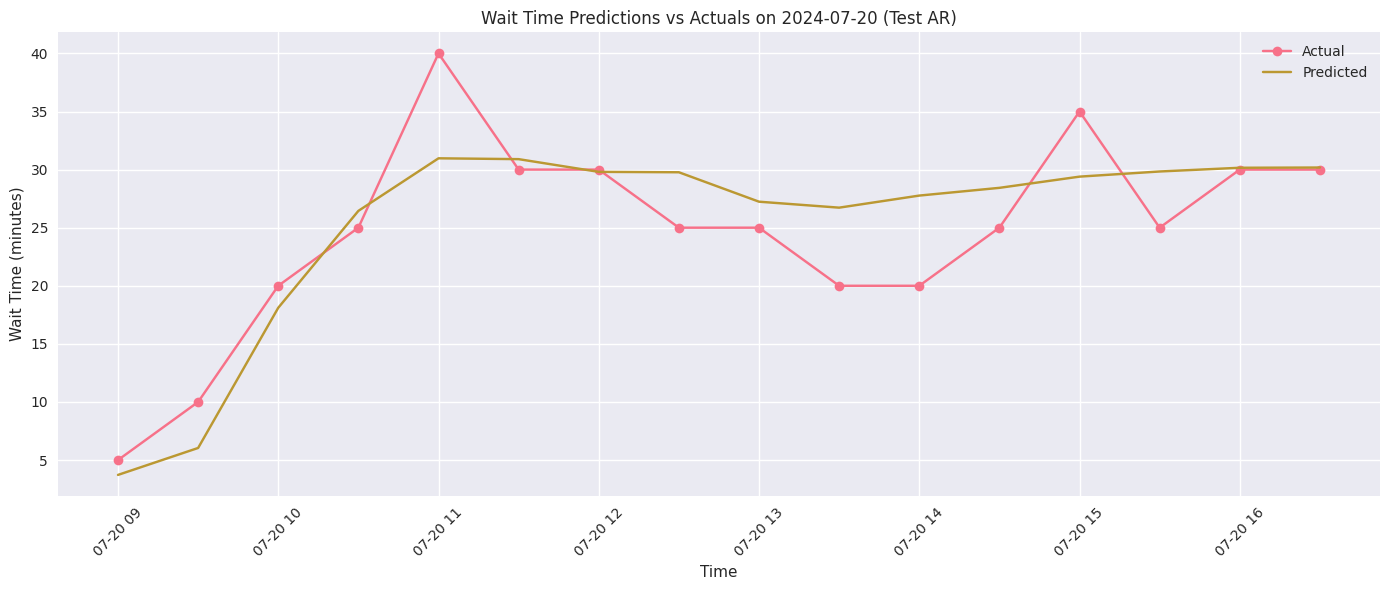

In [4]:
def plot_day_prediction(df, predictor, date, title_suffix=""):
    """
    Plot actual vs predicted wait times for a specific day.
    
    Parameters:
        df (pd.DataFrame): The predictions dataframe (e.g., test_ar or val_ar)
        predictor (WaitTimePredictor): The model predictor (for sequence length)
        date (str or datetime.date): Date string in 'YYYY-MM-DD' format or datetime.date
        title_suffix (str): Optional label for TF/AR etc.
    """
    import matplotlib.pyplot as plt

    # Filter for valid predictions (after warmup and not closed)
    valid_df = df.iloc[predictor.seq_length:].copy()
    valid_df = valid_df[valid_df['closed'] == 0]
    
    # Ensure date is in datetime.date format
    if isinstance(date, str):
        date = pd.to_datetime(date).date()

    day_df = valid_df[valid_df['analysis_date'] == date]
    
    if day_df.empty:
        print(f"⚠️ No data found for {date}")
        return

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(day_df['timestamp'], day_df['wait_time'], label='Actual', marker='o')
    plt.plot(day_df['timestamp'], day_df['wait_time_prediction'], label='Predicted', marker='x')
    
    plt.title(f'Wait Time Predictions vs Actuals on {date} {title_suffix}')
    plt.xlabel('Time')
    plt.ylabel('Wait Time (minutes)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
plot_day_prediction(results['test_ar'], predictor, '2024-07-20', title_suffix="(Test AR)")


In [5]:
results["val_ar"][results["val_ar"]["timestamp"].dt.hour == 9]

timestamp  wait_time  closed  is_german_holiday  \
22061 2023-04-01 09:00:00        5.0       0                  0   
22062 2023-04-01 09:30:00        5.0       0                  0   
22077 2023-04-02 09:00:00        5.0       0                  0   
22078 2023-04-02 09:30:00        5.0       0                  0   
22093 2023-04-03 09:00:00       10.0       0                  0   
...                   ...        ...     ...                ...   
25518 2023-11-03 09:30:00       20.0       0                  0   
25533 2023-11-04 09:00:00       10.0       0                  0   
25534 2023-11-04 09:30:00       30.0       0                  0   
25549 2023-11-05 09:00:00       10.0       0                  0   
25550 2023-11-05 09:30:00       15.0       0                  0   

       is_swiss_holiday  is_french_holiday  day_of_week  temperature  \
22061                 0                  0            5    -1.409812   
22062                 0                  0            5    -1.433702   
22077                 0                  0            6    -1.409812   
22078                 0                  0            6    -1.366730   
22093                 0                  0            0    -1.916064   
...                 ...                ...          ...          ...   
25518                 0                  0            4    -1.515991   
25533                 0                  0            5    -1.423495   
25534                 0                  0            5    -1.356869   
25549                 0                  0            6    -1.067750   
25550                 0                  0            6    -1.049869   

           rain  weekday  ...  analysis_month  analysis_week  \
22061  1.151900        5  ...               4             13   
22062  1.151900        5  ...               4             13   
22077 -0.233942        6  ...               4             13   
22078 -0.233942        6  ...               4             13   
22093 -0.233942        0  ...               4             14   
...         ...      ...  ...             ...            ...   
25518 -0.233942        4  ...              11             44   
25533 -0.233942        5  ...              11             44   
25534 -0.233942        5  ...              11             44   
25549  0.458979        6  ...              11             44   
25550  0.458979        6  ...              11             44   

       analysis_day_name  analysis_hour  analysis_date  baseline_prediction  \
22061           Saturday              9     2023-04-01             4.234094   
22062           Saturday              9     2023-04-01             4.650762   
22077             Sunday              9     2023-04-02             8.793199   
22078             Sunday              9     2023-04-02             9.173186   
22093             Monday              9     2023-04-03             8.735428   
...                  ...            ...            ...                  ...   
25518             Friday              9     2023-11-03            10.939482   
25533           Saturday              9     2023-11-04            11.232524   
25534           Saturday              9     2023-11-04            12.518893   
25549             Sunday              9     2023-11-05             6.662709   
25550             Sunday              9     2023-11-05             7.352773   

       residual_prediction  wait_time_prediction  prediction_mode  \
22061             0.000000              4.234094   Autoregressive   
22062             0.000000              4.650762   Autoregressive   
22077             0.000000              8.793199   Autoregressive   
22078             0.000000              9.173186   Autoregressive   
22093             0.000000              8.735428   Autoregressive   
...                    ...                   ...              ...   
25518             7.106761             18.046243   Autoregressive   
25533            18.181622             29.414146   Autoregressive   
25534  